# Graph Neural Network for identifying Twitter bots
One of the most compelling reasons to employ GNNs over classical machine learning models, especially for predicting Twitter bots within a network, is their **ability to handle relational data effectively**. Twitter networks, where users (nodes) are connected by various types of interactions (edges), such as retweets and replies, are prime examples of complex graph structures. **Classical machine learning models often struggle with this type of data due to their inability to natively understand the connections and the flow of information within the network.** In contrast, GNNs can directly model these relationships, enabling them to detect subtle patterns indicative of bot-like behavior that classical models might miss.

---------------------------------------------------------------------------------------------------------------------------------------------

For this model training, we will be comparing the performance of GNNs against classical ML models using accuracy, precision, recall and f1-score. We will also seek to identify the factors causing the misclassification of humans as bots or bots as humans by the best performing GNN model, such as the types of bots and their tweets.

---------------------------------------------------------------------------------------------------------------------------------------------
**Outline of Content**
1. **`Classical Machine Learning Models`**
2. **`Graph Neural Networks`**
3. **`Analysis of misclassified bots by FinalGraphSAGE model`**
4. **`Comparison of feature selection on FinalGraphSAGE model`**

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

/var/folders/jq/3zk57sh96rj5fmr5m8znw03r0000gn/T/ipykernel_16796/2673924655.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [3]:
u = pd.read_csv("users.csv")
g = pd.read_csv("graph.csv", float_precision='round_trip')

In [4]:
g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315931 entries, 0 to 315930
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   source_user_id   315931 non-null  int64  
 1   target_user_id   315931 non-null  float64
 2   relationship     315931 non-null  object 
 3   tweet_embedding  294962 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.6+ MB


In [5]:
g.head()

,source_user_id,target_user_id,relationship,tweet_embedding
0,20555412,1.445930e+08,Retweet,[ 0.3512645 -0.08518124 0.03606087 -0.206615...
1,2768457999,1.407822e+09,Retweet,[ 1.50224999e-01 3.60594988e-01 1.63409993e-...
2,2768457999,9.390910e+05,Retweet,[-6.35727448e-03 3.19840759e-01 1.26310363e-...
3,2768457999,1.154529e+18,Retweet,[-1.52178392e-01 2.46049643e-01 1.06427386e-...
4,2768457999,3.091246e+08,Retweet,[ 0.46057498 0.21094498 -0.65761 -0.274167...


In [6]:
# cannot match target_user_id to user 
problematic_rows = []
for index, row in g.iterrows():
    try:
        val = u[u["source_user_id"]==row["target_user_id"]]["source_user_id"].values[0]
    except:
        problematic_rows.append(index)

In [7]:
len(problematic_rows)

16766

In [8]:
# drops rows that cannot match
g = g.drop(problematic_rows, axis=0)

In [9]:
# Convert the float to int
def convert_float_to_int(x):
    val = u[u["source_user_id"]==x]["source_user_id"].values[0]
    return val
    
g["target_user_id"] = g["target_user_id"].apply(convert_float_to_int)

In [11]:
def convert_str_to_list(embedding):
    if (pd.isna(embedding)):
        embedding = str(np.zeros(100))
    t = embedding.replace("  ", ",").replace("\n ", ",").replace("\n", ",").replace(" ", ",")
    return [float(x) for x in t[1:-1].split(",") if x != ""]
g["tweet_embedding"] = g["tweet_embedding"].apply(convert_str_to_list)

# 1) Classical Machine Learning Models
We will be training using only the **top 10 selected user features** on the following models to be used as baseline against our GNN models:
1. `Logistic Regression`
2. `K Nearest Neighbour`
3. `Support Vector Machine`
4. `Random Forest Classifier`
5. `XGBoost Classifier`

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = u["label"]
X = u[['mention_max_tweets','hashtags_max_tweets','retweet_ratio','url_tweet_count','hashtag_count_tweets','tweet_count',
 'time_interval_sd_day','followers_count','verified','listed_count']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1.1) Logistic Regression

In [232]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(max_iter=100000)
logistic_classifier.fit(X_train_scaled, y_train)
y_pred_logistic = logistic_classifier.predict(X_test_scaled)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic, average='binary')
recall_logistic = recall_score(y_test, y_pred_logistic, average='binary')
f1_logistic = f1_score(y_test, y_pred_logistic)

print("Logistic Regression Classifier:")
print("Test Accuracy:", accuracy_logistic)
print("Test Precision:", precision_logistic)
print("Test Recall:", recall_logistic)
print("Test F1-score:", f1_logistic)

Logistic Regression Classifier:
Test Accuracy: 0.7686192086265192
Test Precision: 0.6923682140047207
Test Recall: 0.884066706851517
Test F1-score: 0.7765619484645252


### 1.2) K Nearest Neighbour

In [233]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)
y_pred_knn = knn_classifier.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='binary')
recall_knn = recall_score(y_test, y_pred_knn, average='binary')
f1_knn = f1_score(y_test, y_pred_knn)

print("K-Nearest Neighbors (KNN) Classifier:")
print("Test Accuracy:", accuracy_knn)
print("Test Precision:", precision_knn)
print("Test Recall:", recall_knn)
print("Test F1-score:", f1_knn)

K-Nearest Neighbors (KNN) Classifier:
Test Accuracy: 0.9296353833500868
Test Precision: 0.8950234741784038
Test Recall: 0.9576049829214386
Test F1-score: 0.9252572316055135


### 1.3) Support Vector Machine

In [234]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel = 'linear')
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluate SVM classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='binary')
recall_svm = recall_score(y_test, y_pred_svm, average='binary')
f1_svm = f1_score(y_test, y_pred_svm)

print("Support Vector Machine (SVM) Classifier:")
print("Test Accuracy:", accuracy_svm)
print("Test Precision:", precision_svm)
print("Test Recall:", recall_svm)
print("Test F1-score:", f1_svm)

Support Vector Machine (SVM) Classifier:
Test Accuracy: 0.7646897560084072
Test Precision: 0.6771386430678467
Test Recall: 0.9224432388989351
Test F1-score: 0.7809815429106064


### 1.4) Random Forest Classifier

In [230]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(min_samples_split = 5)
rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

Test Accuracy: 0.950562003107009
Test Precision: 0.9189648658859085
Test Recall: 0.9774964838255977
Test F1-score: 0.9473274267354688


### 1.5) XGBoost Classifier

In [231]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='binary')
recall_xgb = recall_score(y_test, y_pred_xgb, average='binary')
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Classifier:")
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
print("Test F1-score:", f1_xgb)

XGBoost Classifier:
Test Accuracy: 0.95385177739194
Test Precision: 0.9288454161871883
Test Recall: 0.9730761502913402
Test F1-score: 0.9504464723775881


# 2) Graph Neural Networks
1. Constructing the graph structure (**edge_index**, **edge_weight**, **node_features**, ) where the **nodes are represented by the aggregreated tweet embedding + top 10 selected user features**, and **the edge are represented by a reply/retweet relationship between nodes (users)**.
2. Create the pytorch `Data` object.
3. Run `custom_stratified_split` to get training, validation and test masks.
4. Build custom functions for `EarlyStopping`, `train_validate`, `test`.
5. Train and validate on the following GNN models with `Adam Optimizer`, `learning rate = 0.05` and `decay = 0.01`:
   - `Graph Convolutional Network (GCN)`
   - `GraphSAGE`
   - `Graph Attention Network (GAT)`
6. Evaluate model using `accuracy`, `precision`, `recall`, `f1-score` on the test set and plot `confusion matrix`.

### 1. Construct graph structure and aggregate (mean) tweet embedding for all users

In [12]:
# Create a mapping of user IDs to node indices >> change it up to index
user_to_idx = {user_id: idx for idx, user_id in enumerate(u["source_user_id"])}

# Create edge index and edge weight tensors
edge_list = []
edge_weight_dict = {}

for _, row in g.iterrows():
    source_idx = user_to_idx[row['source_user_id']]
    target_idx = user_to_idx[row['target_user_id']]
    idx_pair = (source_idx, target_idx)
    if (idx_pair not in edge_list):
        edge_list.append(idx_pair)
        edge_weight_dict[idx_pair] = 1
    else:
        edge_weight_dict[idx_pair] += 1

edge_weight_list = list(edge_weight_dict.values())

#force it to be contiguous
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

In [213]:
def aggregate_embeddings(user_id):
    user = g[g['source_user_id'] == user_id]
    if user.size != 0:
        embeddings = np.stack(user['tweet_embedding'].values)
    else:
        # if user did not make any tweets
        embeddings = np.zeros((1,100))
    return torch.mean(torch.from_numpy(embeddings), dim=0)

tweet_embedding_tensor = torch.stack([aggregate_embeddings(user_id) for user_id in u["source_user_id"]])
user_features = u[['mention_max_tweets','hashtags_max_tweets','retweet_ratio','url_tweet_count','hashtag_count_tweets','tweet_count',
 'time_interval_sd_day','followers_count','verified','listed_count']]
user_features_tensor = torch.from_numpy(user_features.to_numpy())

In [17]:
print(f"size of user tensor: {user_features_tensor.shape}")
print(f"size of embedding tensor: {tweet_embedding_tensor.shape}")

node_features_tensor = torch.cat((user_features_tensor, tweet_embedding_tensor), dim=1)
print(f"size of combined node tensor: {node_features_tensor.shape}")

label_tensor = torch.from_numpy(u["label"].values)
print(f"size of label tensor: {label_tensor.shape}")

size of user tensor: torch.Size([109425, 11])
size of embedding tensor: torch.Size([109425, 100])
size of combined node tensor: torch.Size([109425, 111])
size of label tensor: torch.Size([109425])


In [18]:
edge_index.shape

torch.Size([2, 132371])

### 2. Run custom_stratified_split with 80% trainset, 10% valset and 10% testset
We will be training the data using the train_mask and evaluate it using the val_mask before testing it on the test_mask to get the final performance scores.

In [239]:
def custom_stratified_split(data, train_ratio, val_ratio, test_ratio):
    
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"
    
    num_nodes = data.num_nodes
    num_classes = int(torch.max(data.y)) + 1
    
    # Masks initialization
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    for class_idx in range(num_classes):
        # Get indices of nodes in the current class
        class_indices = (data.y == class_idx).nonzero(as_tuple=False).view(-1)
        # Shuffle indices
        class_indices = class_indices[torch.randperm(len(class_indices))]
        
        # Compute split sizes
        num_train_per_class = int(len(class_indices) * train_ratio)
        num_val_per_class = int(len(class_indices) * val_ratio)
        
        # Assign masks
        train_mask[class_indices[:num_train_per_class]] = True
        val_mask[class_indices[num_train_per_class:num_train_per_class + num_val_per_class]] = True
        test_mask[class_indices[num_train_per_class + num_val_per_class:]] = True
    
    return train_mask, val_mask, test_mask

### 3. Create pytorch geometric Data object

In [240]:
# create a PyTorch Geometric data object

# tweet embedding + top 11 user features
data = Data(x=node_features_tensor.float(), y=label_tensor.long(), edge_index=edge_index, edge_weight=edge_weight)

train_mask, val_mask, test_mask = custom_stratified_split(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

### 4. Build custom functions for `EarlyStopping`, `train_validate` and `test`

In [241]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

In [249]:
def train(model, data, criterion, optimizer, has_edge_weight=True):
    model.train()
    optimizer.zero_grad()
    if has_edge_weight:
        out = model(data.x, data.edge_index, data.edge_weight)
    else:
        out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

def validate(model, data, criterion, optimizer, has_edge_weight=True):
    model.eval()
    with torch.no_grad():
        if has_edge_weight:
            out = model(data.x, data.edge_index, data.edge_weight)
        else:
            out = model(data.x, data.edge_index)
        loss = criterion(out[val_mask], data.y[val_mask])

        # for BCE Loss
        _, pred = torch.max(out, 1)
        
        # Convert to CPU and numpy for sklearn compatibility
        true_labels = data.y[val_mask].cpu().numpy()
        pred_labels = pred[val_mask].cpu().numpy()
        
        # Calculate precision, recall, and accuracy
        precision = precision_score(true_labels, pred_labels, average='binary')
        recall = recall_score(true_labels, pred_labels, average='binary')
        accuracy = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)
        
    return loss, precision, recall, accuracy, f1

# ----------------------------------------------- Functions for training and testing --------------------------------------------------------

def train_validate(model, data, criterion, optimizer, epoch, early_stopping_patience, has_edge_weight=True):
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=False)
    for epoch in range(epoch):
        loss = train(model, data, criterion, optimizer, has_edge_weight)
        val_loss, val_precision, val_recall, val_acc, val_f1 = validate(model, data, criterion, optimizer, has_edge_weight)
        print(f'Epoch {epoch+1} | Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Acc: {val_acc:.4f}, Val f1: {val_f1:.4f}')
       
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

def test(model, data, criterion, optimizer, has_edge_weight=True, show_cm=True, show_df=False):
    model.eval()
    with torch.no_grad():
        if has_edge_weight:
            out = model(data.x, data.edge_index, data.edge_weight)
        else:
            out = model(data.x, data.edge_index)
        test_loss = criterion(out[test_mask], data.y[test_mask].long())
        pred = out.argmax(dim=1)
        
        # Convert to CPU and numpy for sklearn compatibility
        true_labels = data.y[test_mask].cpu().numpy()
        pred_labels = pred[test_mask].cpu().numpy()
        
        # Calculate precision, recall, and accuracy
        precision = precision_score(true_labels, pred_labels, average='binary')
        recall = recall_score(true_labels, pred_labels, average='binary')
        accuracy = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)

        
    test_pred, test_labels, test_loss, test_precision, test_recall, test_acc, test_f1 = pred[test_mask], data.y[test_mask], test_loss, precision, recall, accuracy, f1
    print(f'Test Loss: {test_loss:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

    # set whether to plot confusion matrix
    if (show_cm):
        cm = confusion_matrix(test_labels.cpu().numpy(), test_pred.cpu().numpy())
        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    # Create a DataFrame with source_user_id, true labels, and predicted labels
    if show_df:
        predicted_id_df = pd.DataFrame({
            'source_user_id': u["source_user_id"][test_mask.cpu().numpy()],
            'true_label': true_labels,
            'predicted_label': pred_labels
        })
        return predicted_id_df

### 5.1.1) GCN Model 1
- `Dimsension: num_features`
- `1 GCNConv layer`
- `Batch Normalization`
- `Dropout: 0.3`
- `Feed-forward network with 2 linear layers`

In [243]:
class GCN1(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features)
        self.conv = GCNConv(num_features, num_features)
        self.dropout = nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(num_features, num_features)
        self.linear2 = torch.nn.Linear(num_features, num_classes)

    def forward(self, x, edge_index, edge_weight):

        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)

        x = self.bn(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.dropout(x)
        
        x = self.linear2(x)

        return x

In [244]:
model = GCN1(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=149, early_stopping_patience=3)

Epoch 1 | Train Loss: 0.7401, Val Loss: 0.7506, Val Precision: 0.1450, Val Recall: 0.0981, Val Acc: 0.3282, Val f1: 0.1170
Epoch 2 | Train Loss: 0.7129, Val Loss: 0.6813, Val Precision: 0.6322, Val Recall: 0.1021, Val Acc: 0.5656, Val f1: 0.1758
Epoch 3 | Train Loss: 0.6924, Val Loss: 0.6655, Val Precision: 0.7355, Val Recall: 0.6761, Val Acc: 0.7427, Val f1: 0.7046
Epoch 4 | Train Loss: 0.6791, Val Loss: 0.6595, Val Precision: 0.6914, Val Recall: 0.7482, Val Acc: 0.7342, Val f1: 0.7187
Epoch 5 | Train Loss: 0.6721, Val Loss: 0.6566, Val Precision: 0.6670, Val Recall: 0.7873, Val Acc: 0.7251, Val f1: 0.7222
Epoch 6 | Train Loss: 0.6658, Val Loss: 0.6549, Val Precision: 0.6500, Val Recall: 0.8085, Val Acc: 0.7156, Val f1: 0.7206
Epoch 7 | Train Loss: 0.6607, Val Loss: 0.6536, Val Precision: 0.6381, Val Recall: 0.8252, Val Acc: 0.7083, Val f1: 0.7197
Epoch 8 | Train Loss: 0.6584, Val Loss: 0.6527, Val Precision: 0.6286, Val Recall: 0.8369, Val Acc: 0.7016, Val f1: 0.7179
Epoch 9 | Train 

Test Loss: 0.5280, Test Precision: 0.8045, Test Recall: 0.7173, Test Acc: 0.7926, Test F1: 0.7584


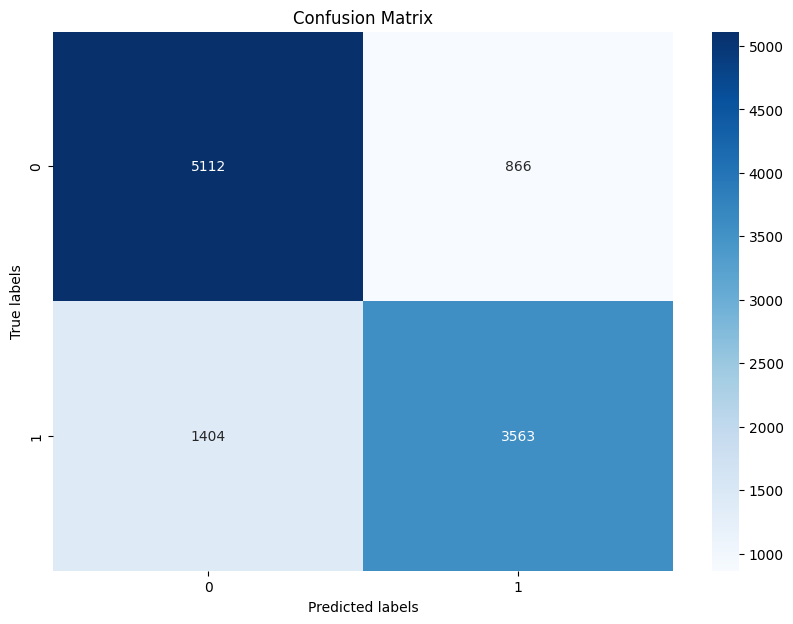

In [250]:
test(model, data, criterion, optimizer, show_cm=True)

### 5.1.1) GCN Model 2 
Instead of 1 GCNConv layer in GCN Model 1, we will be increasing the number of layers to 2 to increase the range of message passing across the nodes.
- `Dimsension: num_features`
- `2 GCNConv layers`
- `Batch Normalization`
- `Dropout: 0.3`
- `Feed-forward network with 2 linear layers`

In [251]:
class GCN2(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features)
        self.conv = GCNConv(num_features, num_features)
        self.dropout = nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(num_features, num_features)
        self.linear2 = torch.nn.Linear(num_features, num_classes)

    def forward(self, x, edge_index, edge_weight):

        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)

        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)

        x = self.bn(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.dropout(x)
        
        x = self.linear2(x)

        return x

In [252]:
model = GCN2(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=149, early_stopping_patience=3)

Epoch 1 | Train Loss: 0.7329, Val Loss: 0.7269, Val Precision: 0.4553, Val Recall: 0.9974, Val Acc: 0.4574, Val f1: 0.6252
Epoch 2 | Train Loss: 0.7170, Val Loss: 0.6901, Val Precision: 0.4982, Val Recall: 0.9420, Val Acc: 0.5432, Val f1: 0.6518
Epoch 3 | Train Loss: 0.7057, Val Loss: 0.6832, Val Precision: 0.5437, Val Recall: 0.9023, Val Acc: 0.6120, Val f1: 0.6785
Epoch 4 | Train Loss: 0.6956, Val Loss: 0.6795, Val Precision: 0.5756, Val Recall: 0.8713, Val Acc: 0.6501, Val f1: 0.6933
Epoch 5 | Train Loss: 0.6890, Val Loss: 0.6774, Val Precision: 0.5826, Val Recall: 0.8548, Val Acc: 0.6562, Val f1: 0.6930
Epoch 6 | Train Loss: 0.6825, Val Loss: 0.6763, Val Precision: 0.5849, Val Recall: 0.8536, Val Acc: 0.6586, Val f1: 0.6941
Epoch 7 | Train Loss: 0.6818, Val Loss: 0.6758, Val Precision: 0.5843, Val Recall: 0.8528, Val Acc: 0.6579, Val f1: 0.6935
Epoch 8 | Train Loss: 0.6773, Val Loss: 0.6754, Val Precision: 0.5843, Val Recall: 0.8526, Val Acc: 0.6578, Val f1: 0.6934
Epoch 9 | Train 

Test Loss: 0.6279, Test Precision: 0.6439, Test Recall: 0.8458, Test Acc: 0.7178, Test F1: 0.7312


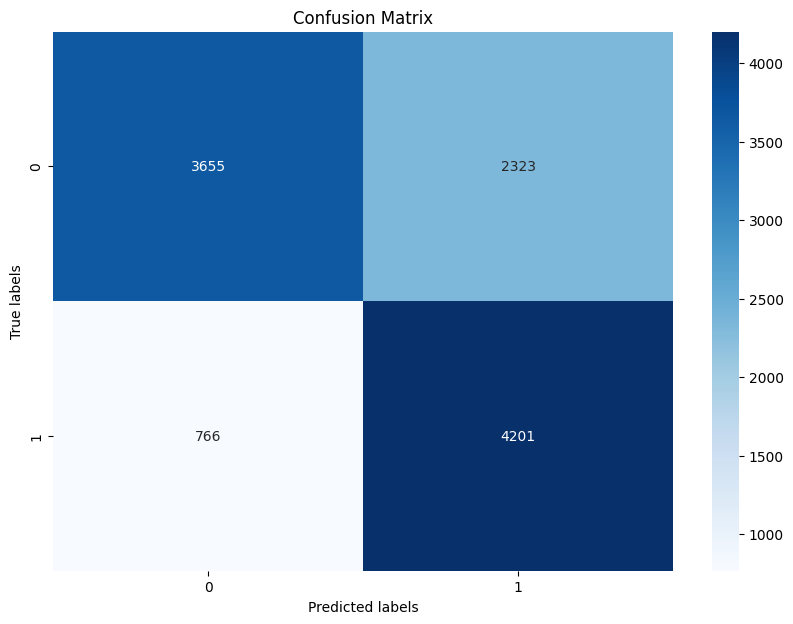

In [253]:
test(model, data, criterion, optimizer, show_cm=True)

### 5.1.2) GCN Model 3
Given the increased performance in GCNConv 1, we have decided to retain only 1 layer of GCNConv as it yields better performance and generalisation. 

We will also increase the input dimension to 128 to introduce more complexities to the model. 
- `Dimsension: 128`
- `1 GCNConv layer`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [254]:
class GCN3(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN3, self).__init__()
        self.bn = torch.nn.BatchNorm1d(128)
        self.linear1 = torch.nn.Linear(num_features, 128)
        self.conv = GCNConv(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(128, 128)
        self.linear3 = torch.nn.Linear(128, num_classes)


    def forward(self, x, edge_index, edge_weight):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)
        
        x = self.bn(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [255]:
model = GCN3(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=149, early_stopping_patience=5)

Epoch 1 | Train Loss: 0.6773, Val Loss: 0.6479, Val Precision: 0.6669, Val Recall: 0.8300, Val Acc: 0.7348, Val f1: 0.7396
Epoch 2 | Train Loss: 0.6684, Val Loss: 0.6453, Val Precision: 0.6415, Val Recall: 0.8600, Val Acc: 0.7184, Val f1: 0.7349
Epoch 3 | Train Loss: 0.6636, Val Loss: 0.6438, Val Precision: 0.6284, Val Recall: 0.8820, Val Acc: 0.7098, Val f1: 0.7339
Epoch 4 | Train Loss: 0.6580, Val Loss: 0.6431, Val Precision: 0.6210, Val Recall: 0.8880, Val Acc: 0.7032, Val f1: 0.7309
Epoch 5 | Train Loss: 0.6554, Val Loss: 0.6427, Val Precision: 0.6146, Val Recall: 0.8947, Val Acc: 0.6976, Val f1: 0.7286
Epoch 6 | Train Loss: 0.6526, Val Loss: 0.6417, Val Precision: 0.6098, Val Recall: 0.8999, Val Acc: 0.6933, Val f1: 0.7270
Epoch 7 | Train Loss: 0.6495, Val Loss: 0.6402, Val Precision: 0.6081, Val Recall: 0.9023, Val Acc: 0.6918, Val f1: 0.7266
Epoch 8 | Train Loss: 0.6461, Val Loss: 0.6379, Val Precision: 0.6092, Val Recall: 0.9015, Val Acc: 0.6929, Val f1: 0.7271
Epoch 9 | Train 

Test Loss: 0.5658, Test Precision: 0.6917, Test Recall: 0.8838, Test Acc: 0.7685, Test F1: 0.7760


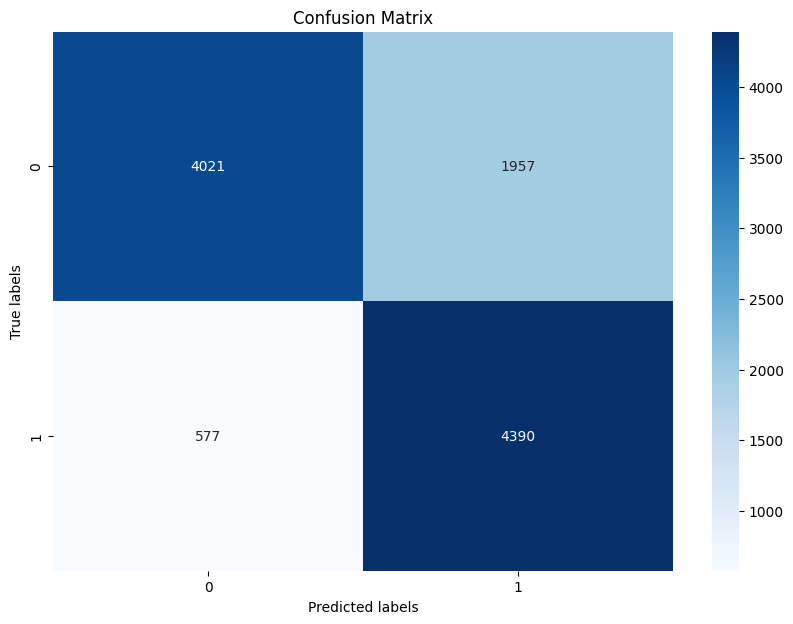

In [256]:
test(model, data, criterion, optimizer, show_cm=True)

### 5.1.4) GCN Model 4
We reduced the input dimension to 64 and also adding a batch normalization layer before the linear layer. 

Intuitively, model performance improves significantly with the addition of a batch normalization layer after the input.

- `Dimsension: 64`
- `Batch Normalization and feed-forward after input layer`
- `1 GCNConv layer`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [257]:
class GCN4(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN4, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = GCNConv(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 64)
        self.linear3 = torch.nn.Linear(64, num_classes)


    def forward(self, x, edge_index, edge_weight):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)
        
        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [258]:
model = GCN4(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, early_stopping_patience=5)

Epoch 1 | Train Loss: 0.6966, Val Loss: 0.6920, Val Precision: 0.3134, Val Recall: 0.0042, Val Acc: 0.5439, Val f1: 0.0083
Epoch 2 | Train Loss: 0.6939, Val Loss: 0.6898, Val Precision: 0.3488, Val Recall: 0.0030, Val Acc: 0.5450, Val f1: 0.0060
Epoch 3 | Train Loss: 0.6912, Val Loss: 0.6886, Val Precision: 0.4138, Val Recall: 0.0024, Val Acc: 0.5457, Val f1: 0.0048
Epoch 4 | Train Loss: 0.6884, Val Loss: 0.6878, Val Precision: 0.4091, Val Recall: 0.0018, Val Acc: 0.5458, Val f1: 0.0036
Epoch 5 | Train Loss: 0.6864, Val Loss: 0.6874, Val Precision: 0.4737, Val Recall: 0.0018, Val Acc: 0.5461, Val f1: 0.0036
Epoch 6 | Train Loss: 0.6843, Val Loss: 0.6871, Val Precision: 0.5000, Val Recall: 0.0016, Val Acc: 0.5462, Val f1: 0.0032
Epoch 7 | Train Loss: 0.6823, Val Loss: 0.6870, Val Precision: 0.4615, Val Recall: 0.0012, Val Acc: 0.5461, Val f1: 0.0024
Epoch 8 | Train Loss: 0.6801, Val Loss: 0.6868, Val Precision: 0.7143, Val Recall: 0.0010, Val Acc: 0.5465, Val f1: 0.0020
Epoch 9 | Train 

Test Loss: 0.2345, Test Precision: 0.8819, Test Recall: 0.9322, Test Acc: 0.9126, Test F1: 0.9063


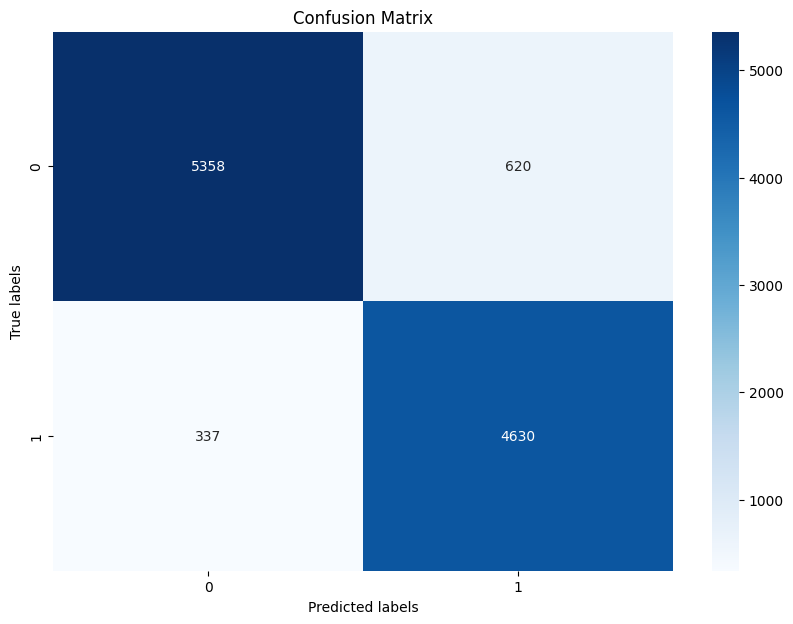

In [259]:
test(model, data, criterion, optimizer, show_cm=True)

### 5.1.5) GCN Model 5
We want to compare if reducing the dimension of the features will retain its performance while reducing complexities. 

Hence we will use dimension=64 after the input and reduce it to 32 before the output. The performance stays the same compared to the previous model hence reducing dimensionality does not affect the performance of the model much.

- `Dimsension: 64 and 32`
- `Batch Normalization and feed-forward after input layer`
- `1 GCNConv layer`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [269]:
class GCN5(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN5, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = GCNConv(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, num_classes)


    def forward(self, x, edge_index, edge_weight):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index, edge_weight=edge_weight))
        x = self.dropout(x)
        
        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [270]:
model = GCN5(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, early_stopping_patience=5)

Epoch 1 | Train Loss: 0.7046, Val Loss: 0.6940, Val Precision: 0.1538, Val Recall: 0.0004, Val Acc: 0.5454, Val f1: 0.0008
Epoch 2 | Train Loss: 0.7013, Val Loss: 0.6930, Val Precision: 0.2000, Val Recall: 0.0004, Val Acc: 0.5457, Val f1: 0.0008
Epoch 3 | Train Loss: 0.6980, Val Loss: 0.6924, Val Precision: 0.3333, Val Recall: 0.0006, Val Acc: 0.5459, Val f1: 0.0012
Epoch 4 | Train Loss: 0.6955, Val Loss: 0.6917, Val Precision: 0.4444, Val Recall: 0.0008, Val Acc: 0.5461, Val f1: 0.0016
Epoch 5 | Train Loss: 0.6924, Val Loss: 0.6911, Val Precision: 0.5000, Val Recall: 0.0008, Val Acc: 0.5462, Val f1: 0.0016
Epoch 6 | Train Loss: 0.6896, Val Loss: 0.6905, Val Precision: 0.5000, Val Recall: 0.0008, Val Acc: 0.5462, Val f1: 0.0016
Epoch 7 | Train Loss: 0.6866, Val Loss: 0.6899, Val Precision: 0.5556, Val Recall: 0.0010, Val Acc: 0.5463, Val f1: 0.0020
Epoch 8 | Train Loss: 0.6849, Val Loss: 0.6893, Val Precision: 0.5000, Val Recall: 0.0010, Val Acc: 0.5462, Val f1: 0.0020
Epoch 9 | Train 

Test Loss: 0.2365, Test Precision: 0.8860, Test Recall: 0.9265, Test Acc: 0.9126, Test F1: 0.9058


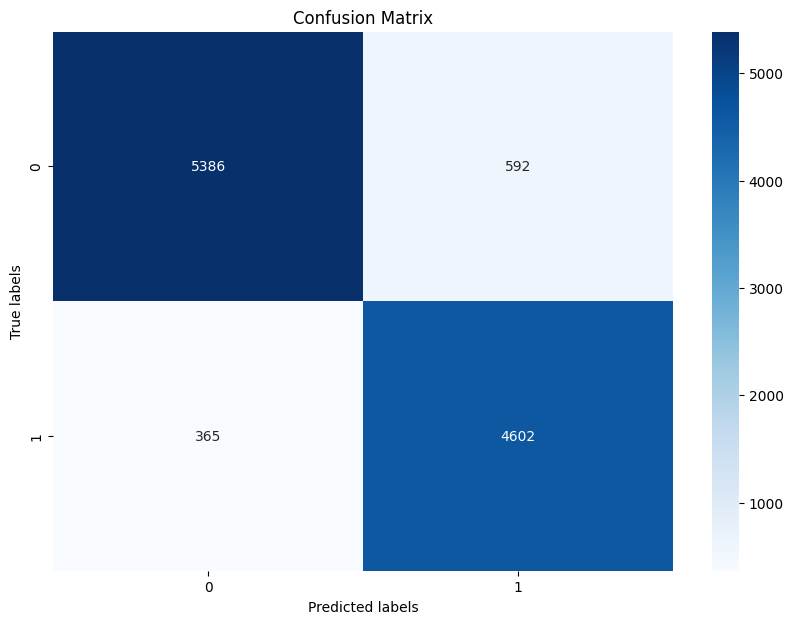

In [271]:
test(model, data, criterion, optimizer, show_cm=True)

### 5.2.1) GraphSAGE Model 1
GraphSAGE's ability to perform inductive learning and its neighborhood sampling technique make it particularly well-suited for identifying bots within a network like Twitter. 

It can also generalize better to unseen nodes not seen in training which aligns with our objective. We will apply the same parameters from GCN Model 5 to the GraphSAGE model. 
- `Dimsension: 64`
- `Batch Normalization and feed-forward after input layer`
- `1 GraphSAGE layer` with `max pooling`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [272]:
from torch_geometric.nn import SAGEConv

class GraphSAGE1(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphSAGE1, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = SAGEConv(64, 64, aggr='max')
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, num_classes)


    def forward(self, x, edge_index):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index))
        x = self.dropout(x)

        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [273]:
model = GraphSAGE1(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.6974, Val Loss: 0.6991, Val Precision: 0.4545, Val Recall: 0.9994, Val Acc: 0.4554, Val f1: 0.6249
Epoch 2 | Train Loss: 0.6837, Val Loss: 0.6987, Val Precision: 0.4541, Val Recall: 0.9996, Val Acc: 0.4544, Val f1: 0.6245
Epoch 3 | Train Loss: 0.6706, Val Loss: 0.6985, Val Precision: 0.4540, Val Recall: 0.9996, Val Acc: 0.4543, Val f1: 0.6244
Epoch 4 | Train Loss: 0.6585, Val Loss: 0.6983, Val Precision: 0.4540, Val Recall: 0.9996, Val Acc: 0.4543, Val f1: 0.6244
Epoch 5 | Train Loss: 0.6465, Val Loss: 0.6978, Val Precision: 0.4541, Val Recall: 0.9996, Val Acc: 0.4544, Val f1: 0.6245
Epoch 6 | Train Loss: 0.6361, Val Loss: 0.6970, Val Precision: 0.4542, Val Recall: 0.9996, Val Acc: 0.4546, Val f1: 0.6246
Epoch 7 | Train Loss: 0.6255, Val Loss: 0.6959, Val Precision: 0.4543, Val Recall: 0.9992, Val Acc: 0.4550, Val f1: 0.6246
Epoch 8 | Train Loss: 0.6153, Val Loss: 0.6945, Val Precision: 0.4548, Val Recall: 0.9990, Val Acc: 0.4560, Val f1: 0.6250
Epoch 9 | Train 

Test Loss: 0.3589, Test Precision: 0.8648, Test Recall: 0.9555, Test Acc: 0.9120, Test F1: 0.9079


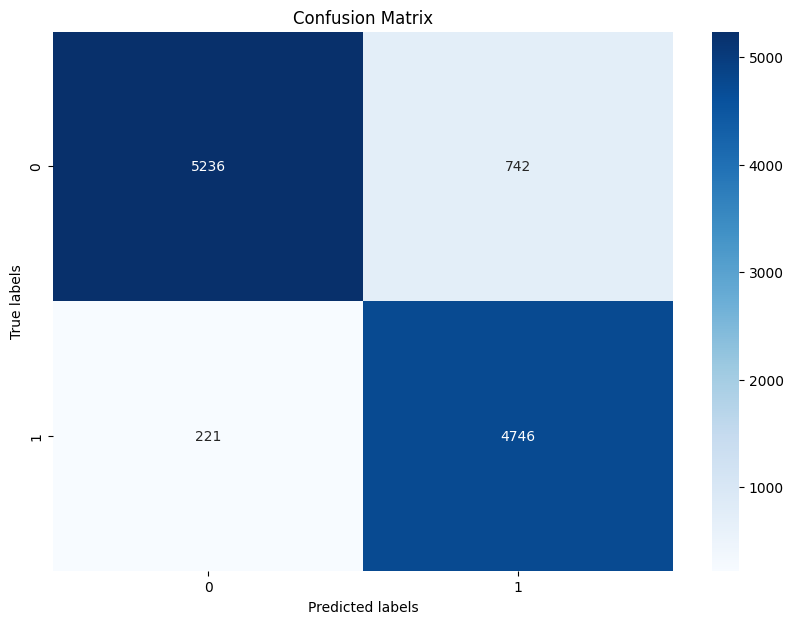

In [268]:
test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

### 5.2.2) GraphSAGE Model 2
We will use the same parameters as GraphSAGE Model 1 but with mean pooling as aggregation.
- `Dimsension: 64 and 32`
- `Batch Normalization and feed-forward after input layer`
- `1 GraphSAGE layer` with `mean pooling`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [178]:
from torch_geometric.nn import SAGEConv

class GraphSAGE2(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphSAGE2, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = SAGEConv(64, 64, aggr='mean')
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, num_classes)


    def forward(self, x, edge_index):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index))
        x = self.dropout(x)

        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [179]:
model = GraphSAGE2(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7091, Val Loss: 0.7039, Val Precision: 0.3179, Val Recall: 0.3684, Val Acc: 0.3546, Val f1: 0.3413
Epoch 2 | Train Loss: 0.6832, Val Loss: 0.6946, Val Precision: 0.4013, Val Recall: 0.1130, Val Acc: 0.5210, Val f1: 0.1763
Epoch 3 | Train Loss: 0.6597, Val Loss: 0.6892, Val Precision: 0.3042, Val Recall: 0.0246, Val Acc: 0.5319, Val f1: 0.0455
Epoch 4 | Train Loss: 0.6398, Val Loss: 0.6854, Val Precision: 0.2065, Val Recall: 0.0077, Val Acc: 0.5363, Val f1: 0.0148
Epoch 5 | Train Loss: 0.6208, Val Loss: 0.6822, Val Precision: 0.2364, Val Recall: 0.0052, Val Acc: 0.5409, Val f1: 0.0102
Epoch 6 | Train Loss: 0.6045, Val Loss: 0.6792, Val Precision: 0.2857, Val Recall: 0.0040, Val Acc: 0.5435, Val f1: 0.0079
Epoch 7 | Train Loss: 0.5892, Val Loss: 0.6759, Val Precision: 0.3710, Val Recall: 0.0046, Val Acc: 0.5447, Val f1: 0.0092
Epoch 8 | Train Loss: 0.5756, Val Loss: 0.6723, Val Precision: 0.4848, Val Recall: 0.0064, Val Acc: 0.5460, Val f1: 0.0127
Epoch 9 | Train 

Test Loss: 0.1820, Test Precision: 0.8978, Test Recall: 0.9662, Test Acc: 0.9348, Test F1: 0.9308


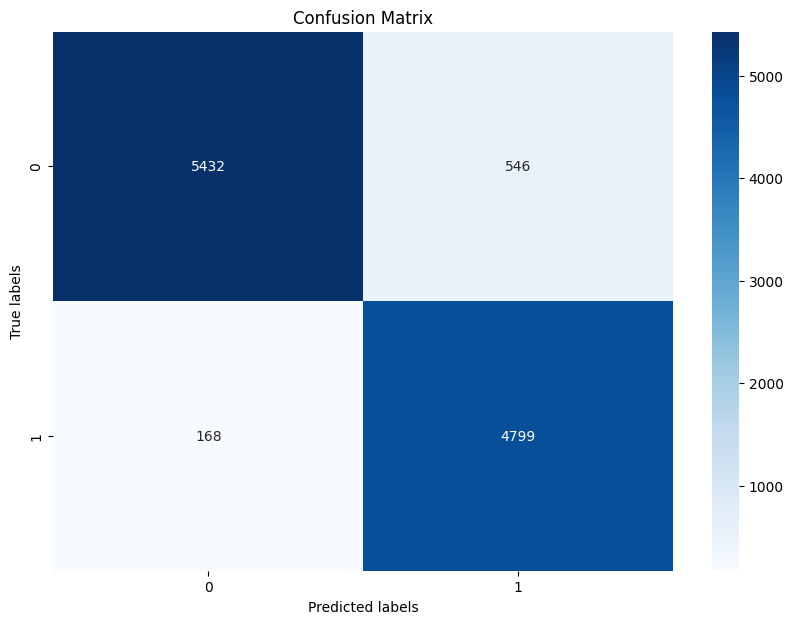

In [274]:
test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

### 5.2.3) GraphSAGE Model 3
We will use the same parameters as GraphSAGE Model 1 but with LSTM as aggregation.
- `Dimsension: 64 and 32`
- `Batch Normalization and feed-forward after input layer`
- `1 GraphSAGE layer` with `LSTM pooling`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [362]:
from torch_geometric.nn import MessagePassing
from torch.nn import LSTM, Linear

class LSTMAggregator(MessagePassing):
    def __init__(self, num_features, num_classes):
        super(LSTMAggregator, self).__init__(aggr='add')
        self.lstm = LSTM(num_features, num_classes, batch_first=True)
        self.lin = Linear(num_features, num_classes)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        x_j = x_j.unsqueeze(1)
        lstm_out, _ = self.lstm(x_j)
        return lstm_out.squeeze(1)

    def update(self, aggr_out, x):
        return self.lin(aggr_out) + x


class GraphSAGE3(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphSAGE3, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = LSTMAggregator(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, num_classes)

    def forward(self, x, edge_index):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index))
        x = self.dropout(x)

        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)

        x = self.linear3(x)

        return x

In [363]:
model = GraphSAGE3(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7202, Val Loss: 0.6929, Val Precision: 0.6010, Val Recall: 0.0240, Val Acc: 0.5499, Val f1: 0.0461
Epoch 2 | Train Loss: 0.7009, Val Loss: 0.6917, Val Precision: 0.6734, Val Recall: 0.1212, Val Acc: 0.5745, Val f1: 0.2055
Epoch 3 | Train Loss: 0.6831, Val Loss: 0.6900, Val Precision: 0.7331, Val Recall: 0.2860, Val Acc: 0.6287, Val f1: 0.4115
Epoch 4 | Train Loss: 0.6676, Val Loss: 0.6874, Val Precision: 0.7723, Val Recall: 0.4139, Val Acc: 0.6786, Val f1: 0.5389
Epoch 5 | Train Loss: 0.6537, Val Loss: 0.6842, Val Precision: 0.8046, Val Recall: 0.4695, Val Acc: 0.7075, Val f1: 0.5930
Epoch 6 | Train Loss: 0.6417, Val Loss: 0.6803, Val Precision: 0.8276, Val Recall: 0.4997, Val Acc: 0.7257, Val f1: 0.6231
Epoch 7 | Train Loss: 0.6297, Val Loss: 0.6757, Val Precision: 0.8556, Val Recall: 0.5192, Val Acc: 0.7421, Val f1: 0.6463
Epoch 8 | Train Loss: 0.6201, Val Loss: 0.6706, Val Precision: 0.8582, Val Recall: 0.5339, Val Acc: 0.7485, Val f1: 0.6583
Epoch 9 | Train 

Test Loss: 0.2171, Test Precision: 0.8898, Test Recall: 0.9555, Test Acc: 0.9261, Test F1: 0.9215


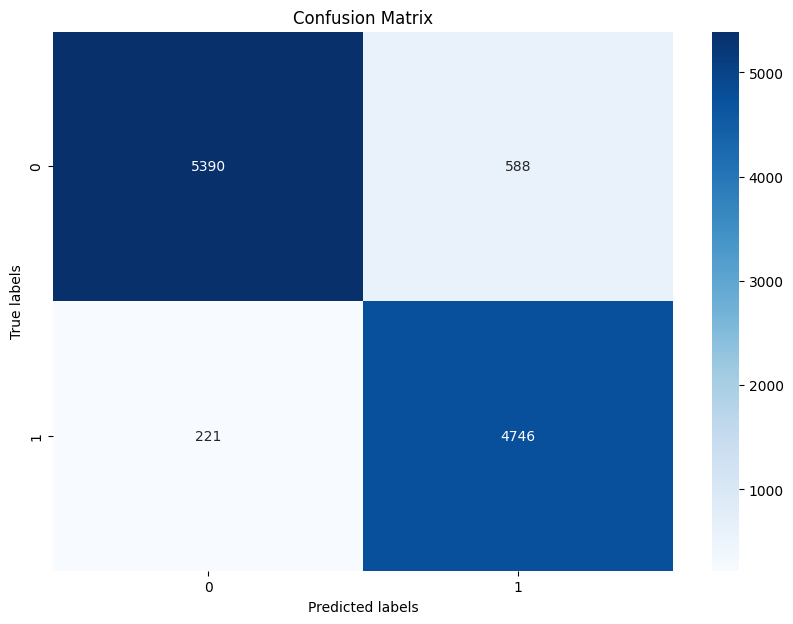

In [364]:
test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

### 5.3.1) GAT Model 1
GAT introduces an attention mechanism to the aggregation step, allowing the model to learn the importance (weights) of each neighbor's features dynamically. This means that instead of treating all neighbors equally or relying on pre-determined weights, GAT can focus more on relevant neighbors for each node. 

We will train the GAT model utilizing the optimised parameter values from GCN 5.
- `Dimsension: 64`
- `Batch Normalization and feed-forward after input layer`
- `1 GAT layer` with `2 heads`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [305]:
from torch_geometric.nn import GATConv

class GAT1(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT1, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features)
        
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(64 * 2)
        
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.layer1 = GATConv(64, 64, heads = 2, dropout = 0.2)
        
        self.dropout = nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(64 * 2, 64)
        self.linear3 = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index):
        x = self.bn(x)
        x = F.leaky_relu(self.linear1(x))

        x = self.bn2(x)
        x = F.leaky_relu(self.layer1(x, edge_index))
        x = self.dropout(x)
        
        x = self.bn3(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)
        return x

In [306]:
model = GAT1(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7250, Val Loss: 0.7005, Val Precision: 0.4492, Val Recall: 0.9801, Val Acc: 0.4457, Val f1: 0.6161
Epoch 2 | Train Loss: 0.7104, Val Loss: 0.6996, Val Precision: 0.4537, Val Recall: 0.9998, Val Acc: 0.4537, Val f1: 0.6242
Epoch 3 | Train Loss: 0.6979, Val Loss: 0.6980, Val Precision: 0.4532, Val Recall: 0.9974, Val Acc: 0.4527, Val f1: 0.6232
Epoch 4 | Train Loss: 0.6857, Val Loss: 0.6951, Val Precision: 0.4288, Val Recall: 0.8896, Val Acc: 0.4121, Val f1: 0.5787
Epoch 5 | Train Loss: 0.6770, Val Loss: 0.6927, Val Precision: 0.4599, Val Recall: 0.5392, Val Acc: 0.5035, Val f1: 0.4964
Epoch 6 | Train Loss: 0.6681, Val Loss: 0.6904, Val Precision: 0.6857, Val Recall: 0.2056, Val Acc: 0.5967, Val f1: 0.3164
Epoch 7 | Train Loss: 0.6600, Val Loss: 0.6882, Val Precision: 0.7646, Val Recall: 0.0818, Val Acc: 0.5719, Val f1: 0.1477
Epoch 8 | Train Loss: 0.6517, Val Loss: 0.6861, Val Precision: 0.6888, Val Recall: 0.0272, Val Acc: 0.5530, Val f1: 0.0523
Epoch 9 | Train 

Test Loss: 0.2003, Test Precision: 0.9005, Test Recall: 0.9529, Test Acc: 0.9308, Test F1: 0.9260


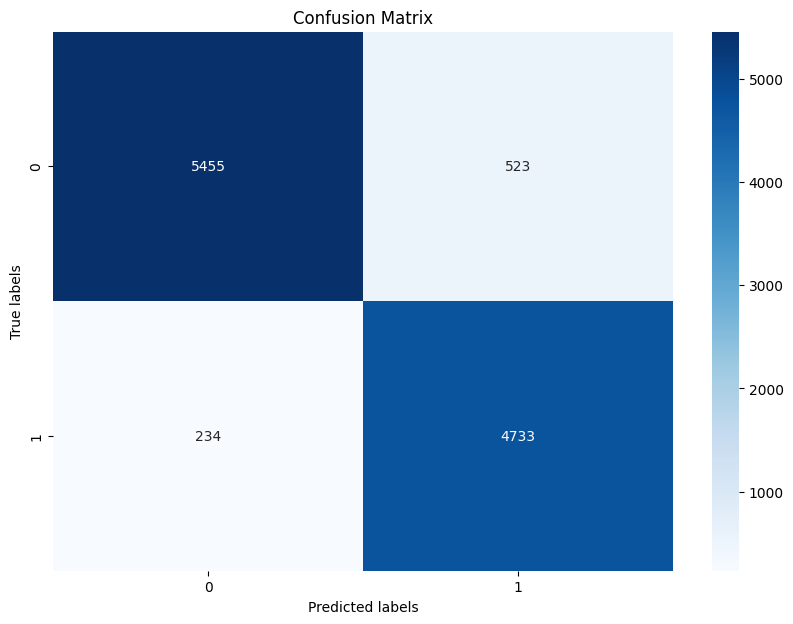

In [307]:
test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

### 5.3.2) GAT Model 2
We will increase the number of attention heads from 2 to 4, ceteris paribus and observe if it can help to differentiate bots from humans better. 
- `Dimsension: 64`
- `Batch Normalization and feed-forward after input layer`
- `1 GAT layer` with `4 heads`
- `Batch Normalization`
- `Dropout: 0.2`
- `Feed-forward network with 2 linear layers`

In [308]:
class GAT2(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT2, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features)
        
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(64 * 4)
        
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.layer1 = GATConv(64, 64, heads = 4, dropout = 0.2)
        
        self.dropout = nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(64 * 4, 64)
        self.linear3 = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index):
        x = self.bn(x)
        x = F.leaky_relu(self.linear1(x))

        x = self.bn2(x)
        x = F.leaky_relu(self.layer1(x, edge_index))
        x = self.dropout(x)
        
        x = self.bn3(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)
        return x

In [309]:
model = GAT2(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=20)

Epoch 1 | Train Loss: 0.6880, Val Loss: 0.6998, Val Precision: 0.4536, Val Recall: 0.9994, Val Acc: 0.4535, Val f1: 0.6240
Epoch 2 | Train Loss: 0.6721, Val Loss: 0.6944, Val Precision: 0.4120, Val Recall: 0.7875, Val Acc: 0.3935, Val f1: 0.5410
Epoch 3 | Train Loss: 0.6604, Val Loss: 0.6908, Val Precision: 0.6282, Val Recall: 0.2508, Val Acc: 0.5926, Val f1: 0.3584
Epoch 4 | Train Loss: 0.6511, Val Loss: 0.6883, Val Precision: 0.7102, Val Recall: 0.0548, Val Acc: 0.5609, Val f1: 0.1017
Epoch 5 | Train Loss: 0.6414, Val Loss: 0.6862, Val Precision: 0.5273, Val Recall: 0.0058, Val Acc: 0.5465, Val f1: 0.0116
Epoch 6 | Train Loss: 0.6320, Val Loss: 0.6845, Val Precision: 0.3333, Val Recall: 0.0014, Val Acc: 0.5456, Val f1: 0.0028
Epoch 7 | Train Loss: 0.6240, Val Loss: 0.6837, Val Precision: 0.3750, Val Recall: 0.0006, Val Acc: 0.5460, Val f1: 0.0012
Epoch 8 | Train Loss: 0.6153, Val Loss: 0.6838, Val Precision: 0.3333, Val Recall: 0.0004, Val Acc: 0.5460, Val f1: 0.0008
EarlyStopping co

Test Loss: 0.2020, Test Precision: 0.9066, Test Recall: 0.9398, Test Acc: 0.9287, Test F1: 0.9229


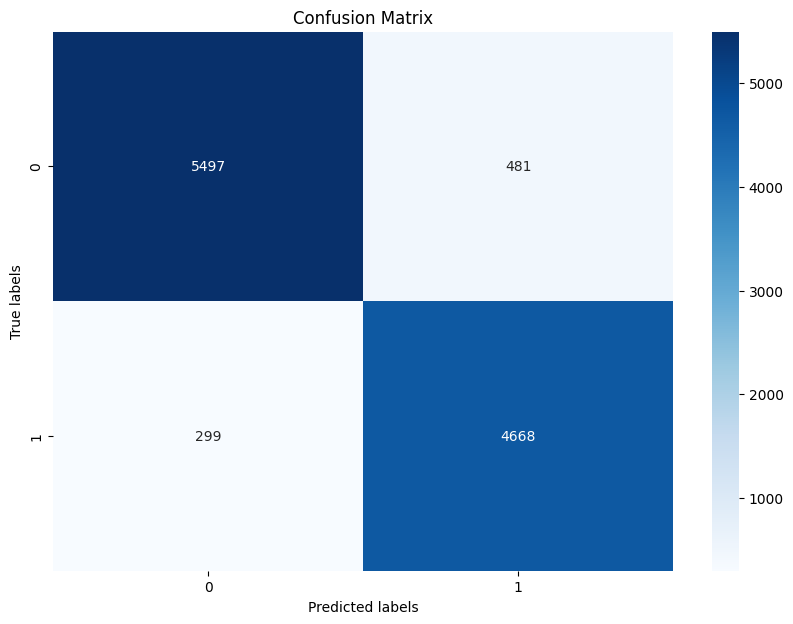

In [310]:
test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

### Evaluation of GNN and classical ML models
We concluded that **GraphSAGE model 2** has the best performance among all the GNNs, across all metrics on the test set. Furthermore, given the inductive nature of the model, together with neighbourhood sampling, GraphSAGE is known to generalize well to unseen samples which aligns perfectly with our objective of identifying twitter bots.

**Our optimized GNN model and classical models achieved the following results**

1. `Optimized GraphSAGE model`: Test Precision: 0.9066, Test Recall: 0.9398, Test Acc: 0.9287, Test F1-score: 0.9229
2. `Logistic Regression`: Test Accuracy: 0.7686192086265192, Test Precision: 0.6923682140047207, Test Recall: 0.884066706851517, Test F1-score: 0.7765619484645252
3. `SVC`: Test Accuracy: 0.7646897560084072, Test Precision: 0.6771386430678467, Test Recall: 0.9224432388989351, Test F1-score: 0.7809815429106064
4. `XGBoost`: Test Accuracy: 0.95385177739194, Test Precision: 0.9288454161871883, Test Recall: 0.9730761502913402, Test F1-score: 0.9504464723775881
5. `Random Forest`: Test Accuracy: 0.950562003107009, Test Precision: 0.9189648658859085, Test Recall: 0.9774964838255977, Test F1-score: 0.9473274267354688
6. `K Nearest Neighbour`: Test Accuracy: 0.9296353833500868, Test Precision: 0.8950234741784038, Test Recall: 0.9576049829214386, Test F1-score: 0.9252572316055135

As observed, Logistic Regression and SVC performs worse across all metrics, while XGBoost and Random Forest performs marginally better. K Nearest Neighbor has about the same performance as our GNN model.

**The better results on the XGBoost and Random Forest could be attributed to 2 reasons:**

1. Limited Data: GNN's are complex to train and require extensive data to train and finetune, which we do not have access to due to limited computational resources. Without a complete dataset, our GNN will also only have sparse connections amongst the many nodes. Coupled with the fact that XGBoost and Random Forest are not data demanding methods, it might have caused the difference in performance.

2. Model Goals: The eventual aim of our GNN is to create a robust model that can detect bot patterns over time. Ideally, it would be resilient against bot evolution across time. As such, it may not as accurate as classical methods with the available cross sectional data.

In [337]:
class FinalGraphSAGE(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FinalGraphSAGE, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.linear1 = torch.nn.Linear(num_features, 64)
        self.conv = SAGEConv(64, 64, aggr='mean')
        self.dropout = nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, num_classes)


    def forward(self, x, edge_index):
        x = self.bn1(x)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.conv(x, edge_index))
        x = self.dropout(x)

        x = self.bn2(x)
        x = F.leaky_relu(self.linear2(x))
        x = self.dropout(x)
        
        x = self.linear3(x)

        return x

In [357]:
model_final = FinalGraphSAGE(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model_final, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=5)

Epoch 1 | Train Loss: 0.7247, Val Loss: 0.6949, Val Precision: 0.6000, Val Recall: 0.0006, Val Acc: 0.5463, Val f1: 0.0012


/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 | Train Loss: 0.7040, Val Loss: 0.6908, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5462, Val f1: 0.0000


/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 | Train Loss: 0.6857, Val Loss: 0.6878, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5462, Val f1: 0.0000


/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 | Train Loss: 0.6682, Val Loss: 0.6851, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5462, Val f1: 0.0000


/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 | Train Loss: 0.6526, Val Loss: 0.6820, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5462, Val f1: 0.0000


/Users/hengboonlong/opt/anaconda3/envs/school_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 | Train Loss: 0.6378, Val Loss: 0.6788, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5462, Val f1: 0.0000
Epoch 7 | Train Loss: 0.6245, Val Loss: 0.6756, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5461, Val f1: 0.0000
Epoch 8 | Train Loss: 0.6119, Val Loss: 0.6722, Val Precision: 0.0000, Val Recall: 0.0000, Val Acc: 0.5459, Val f1: 0.0000
Epoch 9 | Train Loss: 0.5997, Val Loss: 0.6687, Val Precision: 0.5000, Val Recall: 0.0010, Val Acc: 0.5462, Val f1: 0.0020
Epoch 10 | Train Loss: 0.5886, Val Loss: 0.6649, Val Precision: 0.8542, Val Recall: 0.0083, Val Acc: 0.5493, Val f1: 0.0164
Epoch 11 | Train Loss: 0.5775, Val Loss: 0.6609, Val Precision: 0.8539, Val Recall: 0.0306, Val Acc: 0.5577, Val f1: 0.0591
Epoch 12 | Train Loss: 0.5667, Val Loss: 0.6565, Val Precision: 0.8658, Val Recall: 0.0975, Val Acc: 0.5836, Val f1: 0.1752
Epoch 13 | Train Loss: 0.5556, Val Loss: 0.6517, Val Precision: 0.8601, Val Recall: 0.1944, Val Acc: 0.6201, Val f1: 0.3171
Epoch 14 | T

# 3) Analysis of misclassified bots by **`FinalGraphSAGE`** model

Test Loss: 0.1627, Test Precision: 0.9050, Test Recall: 0.9688, Test Acc: 0.9397, Test F1: 0.9358


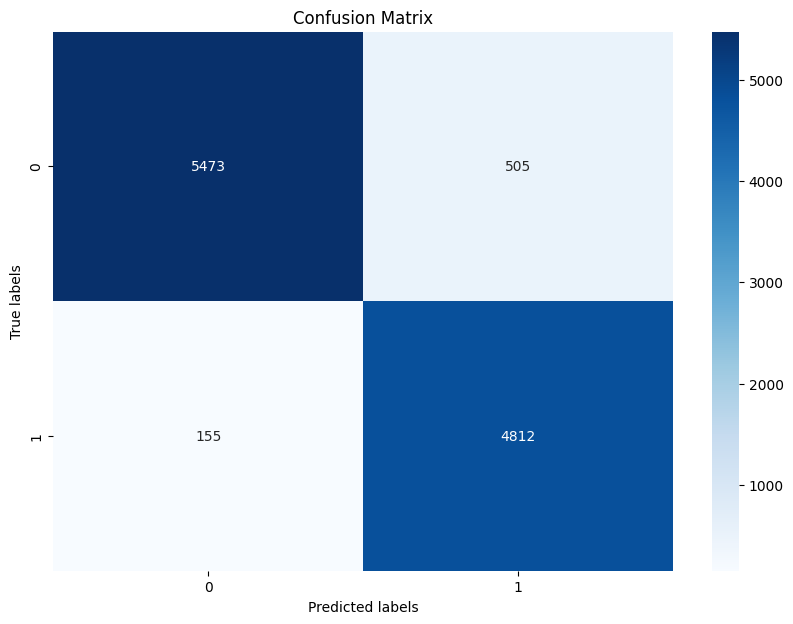

In [365]:
results = test(model_final, data, criterion, optimizer, has_edge_weight=False, show_cm=True, show_df=True)

In [368]:
source_ids_list = results[(results["true_label"] == 1) & (results["predicted_label"] == 0)]['source_user_id']

In [369]:
# load the cluster dataset
bot_clusters = pd.read_csv("bot_clusters_ids.csv")

# Filter DataFrame to only rows where source_id is in your list
filtered_df = bot_clusters[bot_clusters['source_id'].isin(source_ids_list)]

# Get the count of each cluster
cluster_counts = filtered_df['cluster'].value_counts()

print(cluster_counts)

cluster
1    57
2    51
4    36
3     9
0     2
Name: count, dtype: int64


### Explanation for the analysis of misclassified bots
**Clusters 1 and 2 tend to be most commonly misclassified as humans, despite being bots.**
Cluster 1 contains Business and Academic Bots while Cluster 2 contains Technology and Innovation Bots (refer to `Cluster_TFIDF.ipynb`). 
- Bots in business, academic, and technology domains often utilize sophisticated and technical language that mirrors human expertise in these areas. This level of sophistication in language use can make it challenging for detection algorithms to distinguish them from human users, who might use similar terminologies and expressions in their communications

**Cluster 0 contains the least number of misclassified bots.**
Cluster 0 contains Political Bots which have been widely observed to be the least likely to be misclassified and this is synonymous with the following research paper (https://arxiv.org/pdf/2301.07015.pdf).

# 4) Comparison of Feature Selection on **`FinalGraphSAGE`** for Twitter Bot Prediction

On top of building a robust GNN model for Twitter Bot Detection, we also wish to take this opportunity to evaluate the importance of various features with regards to the best performing GNN model, **`FinalGraphSAGE`**. 

As mentioned in our Feature Engineering process, we included features that were derived from many research papers based on their classical and GNN models. As such, we wish to investigate the importance of these features with regards to a specific GNN model. Therefore, we will be comparing the performance of the **`FinalGraphSAGE`** model based on 3 different groups:

1. All: This sets contains the entire set of features, including pre-defined features in the dataset as well as all the features we have engineered. They are all included except url_ratio, which is too small in magnitude, as it would cause a NaN trap possibly due to vanishing gradient.

2. Impt: This set contains the top 10 important features, as selected from Feature Selection and EDA.

3. Elser: This set contains all other features that are not Impt. This is so that we can observe the impact on feeding less 'important' features, that may be less appropriate for a GCN model in this context.



## Selecting 3 different features groups

In [330]:
all = ['url.urls', 'description.urls',
       'description.mentions', 'description.hashtags', 'description.cashtags',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'username_length', 'name_length', 'description_length',
       'numDigits_username', 'username_entropy', 'description_entropy',
       'names_similarity', 'names_ratio', 'reputation', 
       'age_of_account','retweet_ratio', 'url_count_tweets',
       'url_max_tweets', 'time_interval_sd_day',
       'mention_count_tweets', 'mention_max_tweets', 'hashtag_count_tweets',
       'hashtags_max_tweets', 'avg_tweet_length', 'url_tweet_count', 'verified']

impt = ['mention_max_tweets','hashtags_max_tweets','retweet_ratio','url_tweet_count','hashtag_count_tweets','tweet_count',
 'time_interval_sd_day','followers_count','verified','listed_count']

elser = []

for items in all:
    if items not in impt:
        elser.append(items)

## **`FinalGraphSAGE`** trained on all features

In [361]:
user_features = u[all]
user_features_tensor = torch.from_numpy(user_features.to_numpy())

node_features_tensor_all = torch.cat((user_features_tensor, tweet_embedding_tensor), dim=1)
data_all = Data(x=node_features_tensor.float(), y=label_tensor.long(), edge_index=edge_index, edge_weight=edge_weight)

train_mask, val_mask, test_mask = custom_stratified_split(data_all, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

model = FinalGraphSAGE(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7026, Val Loss: 0.7029, Val Precision: 0.4537, Val Recall: 0.9998, Val Acc: 0.4537, Val f1: 0.6242
Epoch 2 | Train Loss: 0.6837, Val Loss: 0.6972, Val Precision: 0.4537, Val Recall: 0.9992, Val Acc: 0.4536, Val f1: 0.6240
Epoch 3 | Train Loss: 0.6652, Val Loss: 0.6947, Val Precision: 0.4524, Val Recall: 0.9921, Val Acc: 0.4514, Val f1: 0.6214
Epoch 4 | Train Loss: 0.6484, Val Loss: 0.6928, Val Precision: 0.4501, Val Recall: 0.9565, Val Acc: 0.4499, Val f1: 0.6121
Epoch 5 | Train Loss: 0.6330, Val Loss: 0.6907, Val Precision: 0.4756, Val Recall: 0.8767, Val Acc: 0.5053, Val f1: 0.6167
Epoch 6 | Train Loss: 0.6183, Val Loss: 0.6882, Val Precision: 0.5778, Val Recall: 0.7807, Val Acc: 0.6416, Val f1: 0.6641
Epoch 7 | Train Loss: 0.6057, Val Loss: 0.6854, Val Precision: 0.7011, Val Recall: 0.7019, Val Acc: 0.7289, Val f1: 0.7015
Epoch 8 | Train Loss: 0.5930, Val Loss: 0.6822, Val Precision: 0.7739, Val Recall: 0.6377, Val Acc: 0.7510, Val f1: 0.6992
Epoch 9 | Train 

All Features
Test Loss: 0.1890, Test Precision: 0.8900, Test Recall: 0.9777, Test Acc: 0.9350, Test F1: 0.9318


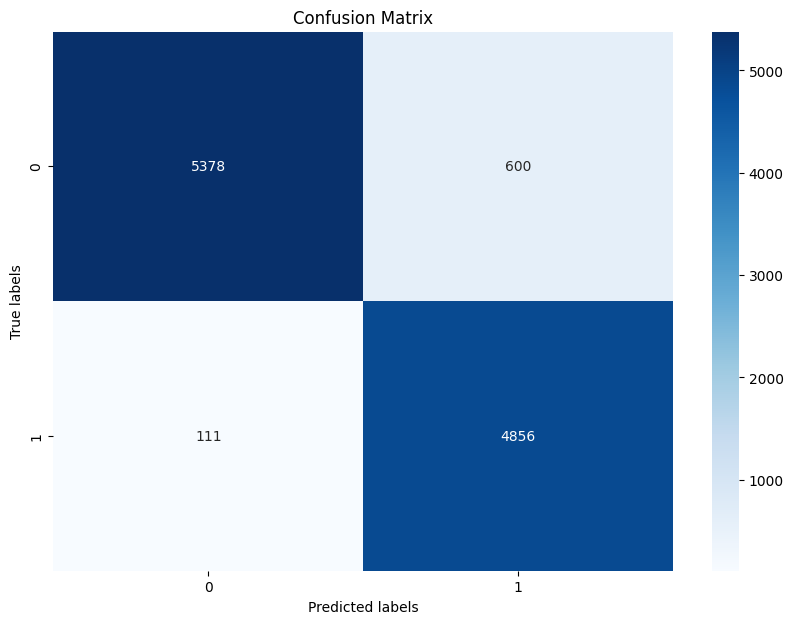

In [332]:
print("All Features")

test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

## **`FinalGraphSAGE`** trained on Important Features

In [333]:
user_features = u[impt]
user_features_tensor = torch.from_numpy(user_features.to_numpy())

node_features_tensor_all = torch.cat((user_features_tensor, tweet_embedding_tensor), dim=1)
data_all = Data(x=node_features_tensor.float(), y=label_tensor.long(), edge_index=edge_index, edge_weight=edge_weight)

train_mask, val_mask, test_mask = custom_stratified_split(data_all, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

model = FinalGraphSAGE(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7249, Val Loss: 0.7113, Val Precision: 0.4538, Val Recall: 1.0000, Val Acc: 0.4539, Val f1: 0.6243
Epoch 2 | Train Loss: 0.7036, Val Loss: 0.7088, Val Precision: 0.4538, Val Recall: 1.0000, Val Acc: 0.4539, Val f1: 0.6243
Epoch 3 | Train Loss: 0.6851, Val Loss: 0.7059, Val Precision: 0.4538, Val Recall: 1.0000, Val Acc: 0.4539, Val f1: 0.6243
Epoch 4 | Train Loss: 0.6692, Val Loss: 0.7030, Val Precision: 0.4538, Val Recall: 1.0000, Val Acc: 0.4539, Val f1: 0.6243
Epoch 5 | Train Loss: 0.6535, Val Loss: 0.7001, Val Precision: 0.4538, Val Recall: 1.0000, Val Acc: 0.4539, Val f1: 0.6243
Epoch 6 | Train Loss: 0.6386, Val Loss: 0.6970, Val Precision: 0.4539, Val Recall: 1.0000, Val Acc: 0.4540, Val f1: 0.6244
Epoch 7 | Train Loss: 0.6236, Val Loss: 0.6939, Val Precision: 0.4540, Val Recall: 1.0000, Val Acc: 0.4543, Val f1: 0.6245
Epoch 8 | Train Loss: 0.6109, Val Loss: 0.6906, Val Precision: 0.4544, Val Recall: 0.9996, Val Acc: 0.4551, Val f1: 0.6247
Epoch 9 | Train 

Important Features
Test Loss: 0.1835, Test Precision: 0.8904, Test Recall: 0.9768, Test Acc: 0.9349, Test F1: 0.9316


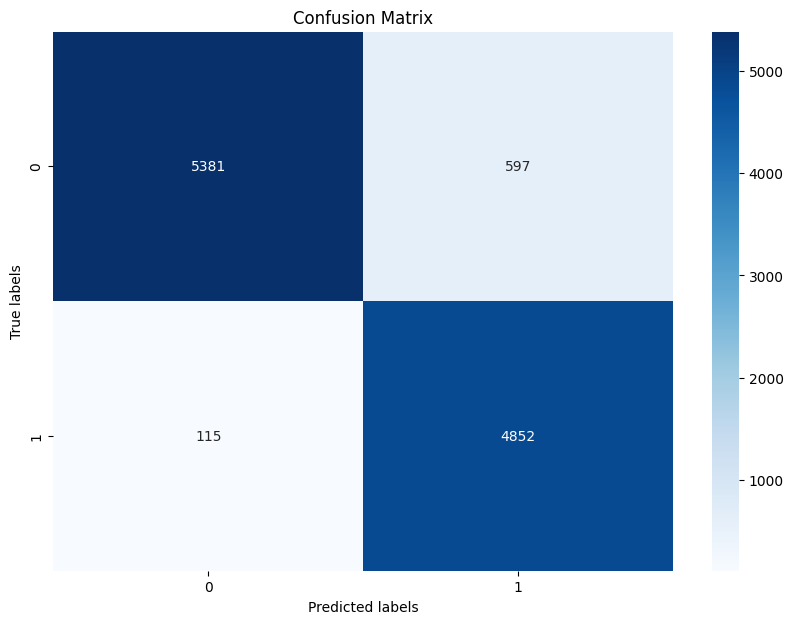

In [334]:
print("Important Features")

test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

## **`FinalGraphSAGE`** trained on Less Important Features

In [335]:
user_features = u[elser]
user_features_tensor = torch.from_numpy(user_features.to_numpy())

node_features_tensor_all = torch.cat((user_features_tensor, tweet_embedding_tensor), dim=1)
data_all = Data(x=node_features_tensor.float(), y=label_tensor.long(), edge_index=edge_index, edge_weight=edge_weight)

train_mask, val_mask, test_mask = custom_stratified_split(data_all, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

model = FinalGraphSAGE(num_features=node_features_tensor.size(1), num_classes=2)

decay = 0.05
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

train_validate(model=model, data=data, criterion=criterion, optimizer=optimizer, epoch=200, has_edge_weight=False, early_stopping_patience=10)

Epoch 1 | Train Loss: 0.7326, Val Loss: 0.6998, Val Precision: 0.4506, Val Recall: 0.9575, Val Acc: 0.4509, Val f1: 0.6128
Epoch 2 | Train Loss: 0.7080, Val Loss: 0.7009, Val Precision: 0.4524, Val Recall: 0.9829, Val Acc: 0.4523, Val f1: 0.6196
EarlyStopping counter: 1 out of 10
Epoch 3 | Train Loss: 0.6875, Val Loss: 0.7004, Val Precision: 0.4528, Val Recall: 0.9883, Val Acc: 0.4526, Val f1: 0.6210
EarlyStopping counter: 2 out of 10
Epoch 4 | Train Loss: 0.6679, Val Loss: 0.6986, Val Precision: 0.4533, Val Recall: 0.9911, Val Acc: 0.4535, Val f1: 0.6221
Epoch 5 | Train Loss: 0.6500, Val Loss: 0.6960, Val Precision: 0.4545, Val Recall: 0.9901, Val Acc: 0.4562, Val f1: 0.6230
Epoch 6 | Train Loss: 0.6352, Val Loss: 0.6931, Val Precision: 0.4589, Val Recall: 0.9851, Val Acc: 0.4660, Val f1: 0.6261
Epoch 7 | Train Loss: 0.6211, Val Loss: 0.6900, Val Precision: 0.4748, Val Recall: 0.9748, Val Acc: 0.4993, Val f1: 0.6386
Epoch 8 | Train Loss: 0.6074, Val Loss: 0.6867, Val Precision: 0.5103

Unimportant
Test Loss: 0.3488, Test Precision: 0.8472, Test Recall: 0.9523, Test Acc: 0.9004, Test F1: 0.8967


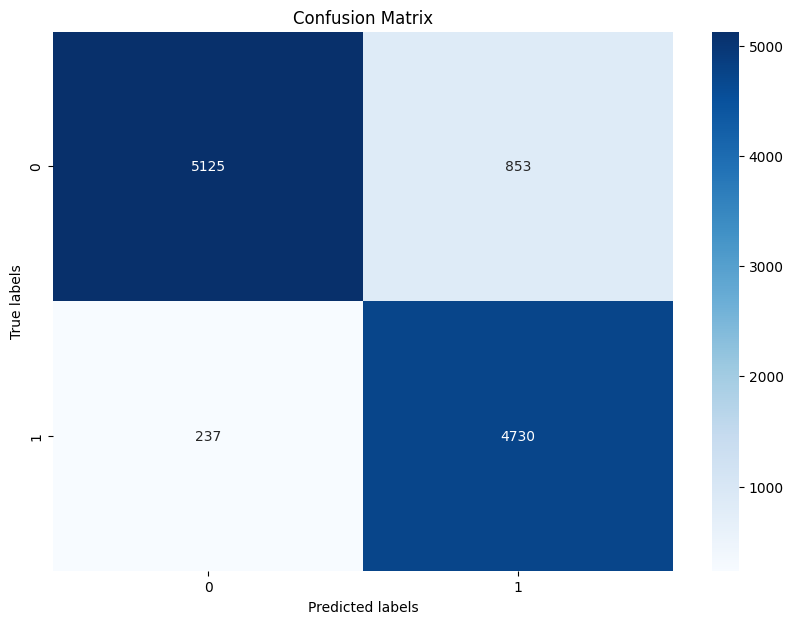

In [336]:
print("Unimportant")

test(model, data, criterion, optimizer, has_edge_weight=False, show_cm=True)

## Conclusion
### The summarized results of the 3 different models are as shown:

1. `All`: Test Precision: 0.8900, Test Recall: 0.9777, Test Acc: 0.9350, Test F1: 0.9318
2. `Important Features`: Test Precision: 0.8904, Test Recall: 0.9768, Test Acc: 0.9349, Test F1: 0.9316
3. `Remaining Features`: Test Precision: 0.8472, Test Recall: 0.9523, Test Acc: 0.9004, Test F1: 0.8967

**The model with Important Features and All Features perform better across all metrics**, and have very similar results. This supports the conclusion from our Feature Selection process, and shows that we were able to effectively reduce the dimensionality of the features across the dataset to about 10 important features, and still maintain a relatively good result. Therefore, we strongly recommend future research on GNN in this domain to utilize the abovementioned features in this subset.

**The model with only the remaining features performs worse across all metrics**, with precision dropping about 4.2% and accuracy dropping by about 3.0%. This highlights that the additional features may not be well suited for a GNN model / may not provide a good distinction between Humans and Bots. As such, we would not recommend them to be utilized in a general GNN model trained for Twitter Bot Classification.